In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
sys.path.append("../")


%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, precision_recall_curve, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from src.data import *

# 1) Read dataset

In [2]:
X,y = load_data()
X.shape, y.shape
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(59400, 30) (59400, 1)
(47520, 30) (11880, 30) (47520, 1) (11880, 1)


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 30 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null float64
gps_height               59400 non-null int64
longitude                59400 non-null float64
latitude                 59400 non-null float64
num_private              59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
population               59400 non-null int64
permit                   56344 non-null object
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management               59400 non-null object
management_group         59400 non-null obj

In [4]:
# save these values for later as they are imputed and scaled for modeling
dexp_train = X_train
dexp_test = X_test
dexp_train_y = y_train
dexp_test_y = y_test

## Data Understanding

### Take a peek at the target data

In [5]:
du_X = pd.read_csv('../data/training_set_values.csv', index_col = 'id')
du_y = pd.read_csv('../data/training_set_labels.csv', index_col = 'id')

In [6]:
'''
    Target Values:
        functional                 32259
        non functional             22824
        functional needs repair     4317
'''
du_y['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [7]:
'''
    Target Values:
        date_recorded             object
        funder                    object
        gps_height                 int64
        installer                 object
        longitude                float64
        latitude                 float64
        wpt_name                  object
        num_private                int64
        basin                     object
        subvillage                object
        region                    object
        region_code                int64
        district_code              int64
        lga                       object
        ward                      object
        population                 int64
        public_meeting            object
        recorded_by               object
        scheme_management         object
        scheme_name               object
        permit                    object
        construction_year          int64
        extraction_type           object
        extraction_type_group     object
        extraction_type_class     object
        management                object
        management_group          object
        payment                   object
        payment_type              object
        water_quality             object
        quality_group             object
        quantity                  object
        quantity_group            object
        source                    object
        source_type               object
        source_class              object
        waterpoint_type           object
        waterpoint_type_group     object
'''
du_X.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

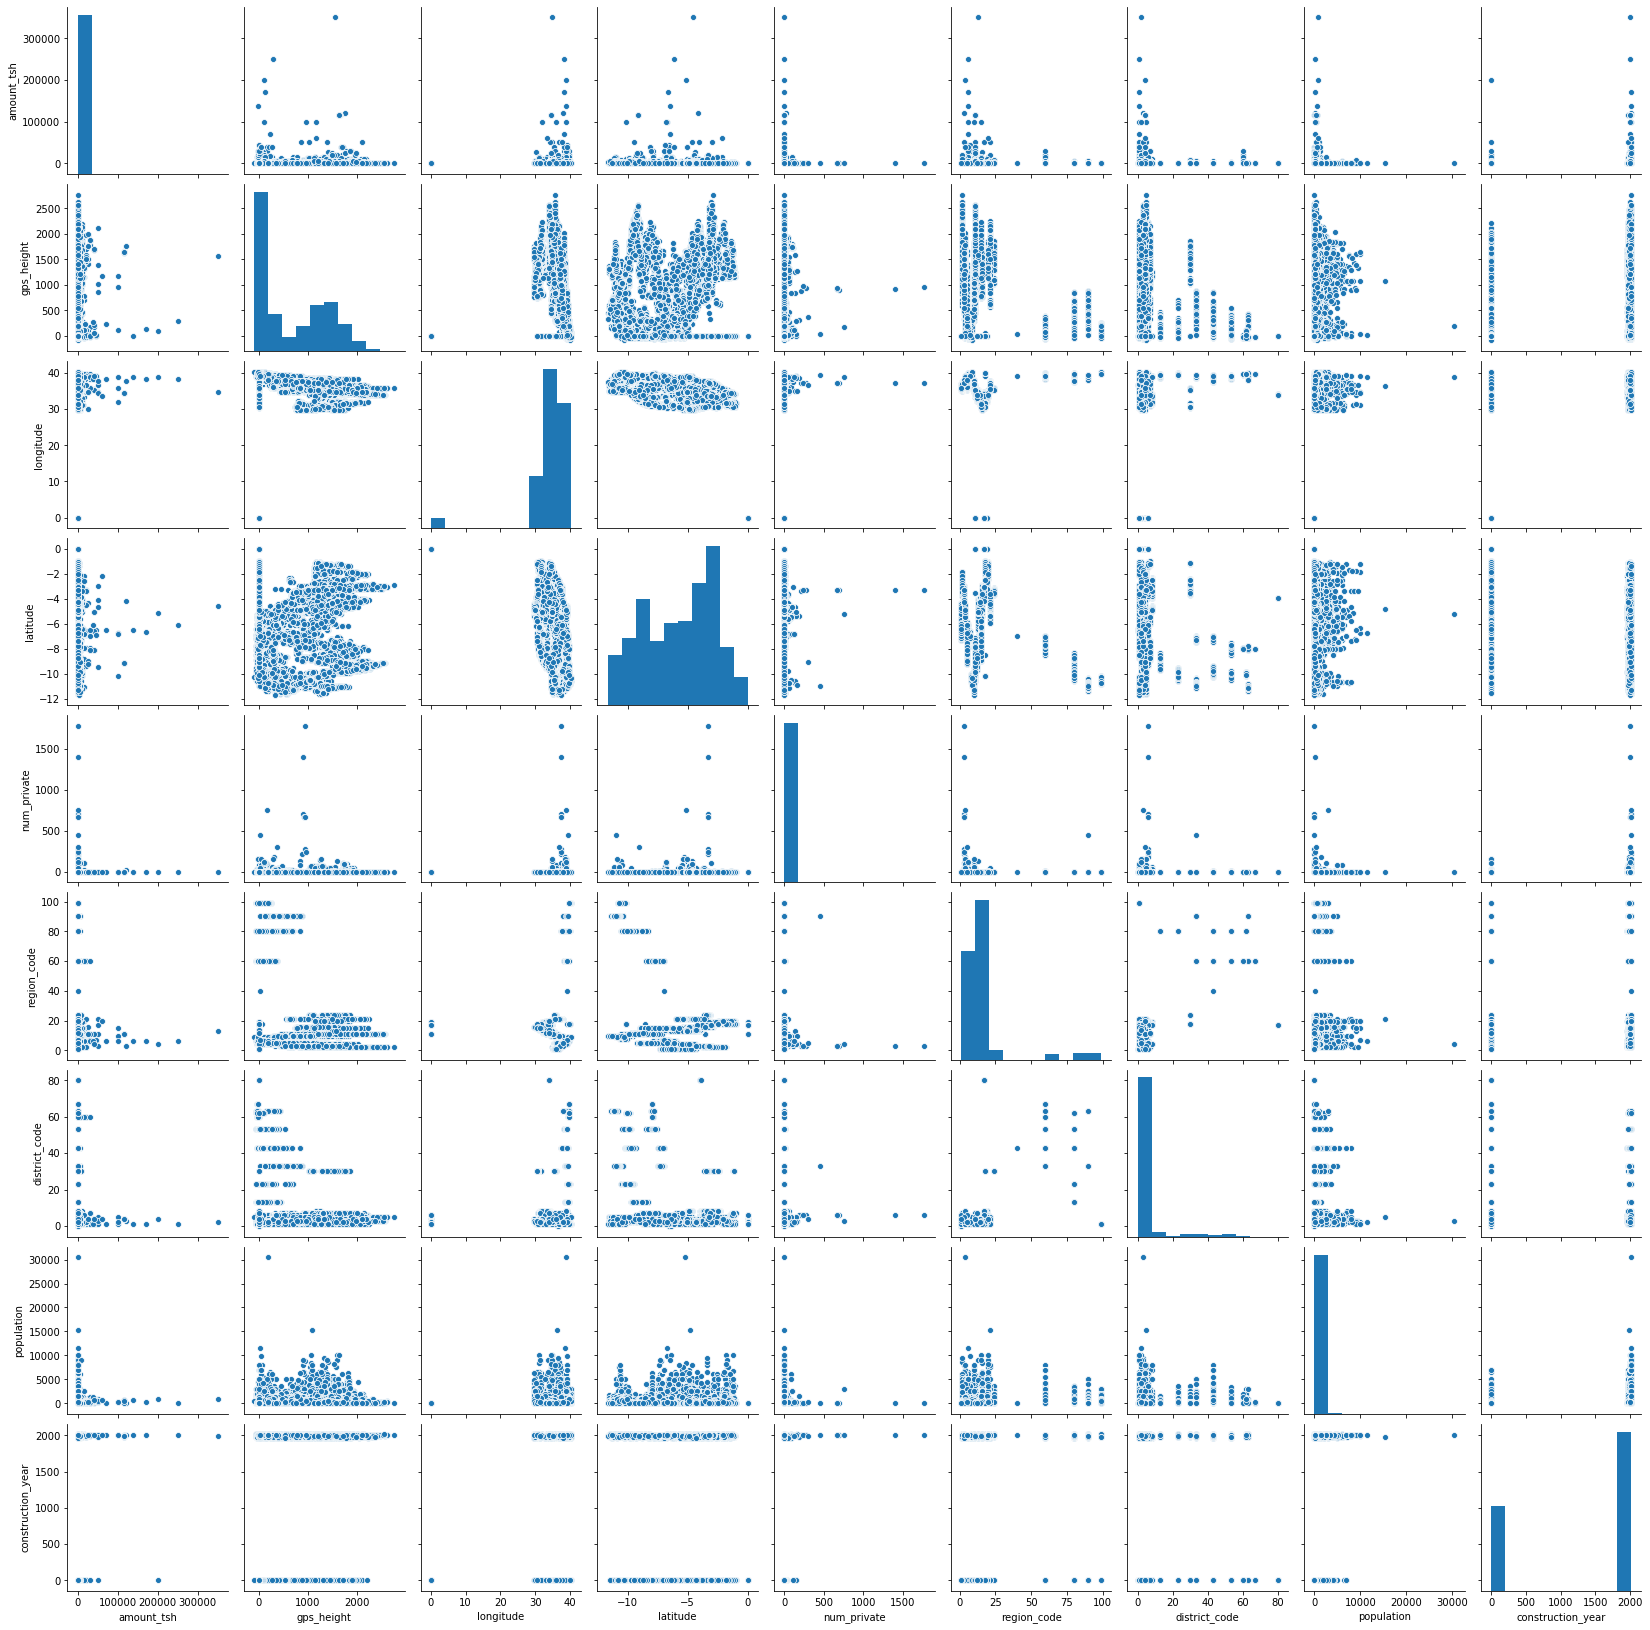

In [8]:
'''
    Pairplot for all numerical features. No obvious patterms observed.
'''
df_num = du_X.select_dtypes(exclude='object')
sns.pairplot(df_num)

In [ ]:
'''
    Pairplot for all categorical features
'''
df_cat = du_X.select_dtypes(include='object')
sns.pairplot(df_num)

### Addional charts are now moved to bottom afer wp_processor does it's data-cleaning is done there..

In [ ]:
'''
    This is neat. load_data() function drops off  some categorical columns with too many values to avoid OHE slaughter..
    Now we have rest of them all non-null values.
    
    For reference, including dropped columns, there is the complete list of features..
                                                                     NaNs
    Data columns (total 30 columns):                       -----------------------
            amount_tsh               59400 non-null float64
            date_recorded            59400 non-null object
            funder                   55765 non-null object ------> funder    3635 
            gps_height               59400 non-null int64  ------> installer 3655
            installer                55745 non-null object
            longitude                59400 non-null float64
            latitude                 59400 non-null float64
            wpt_name                 59400 non-null object
            num_private              59400 non-null int64
            basin                    59400 non-null object
            subvillage               59029 non-null object ------> installer 3655
            region                   59400 non-null object
            region_code              59400 non-null int64
            district_code            59400 non-null int64
            lga                      59400 non-null object
            ward                     59400 non-null object
            population               59400 non-null int64
            public_meeting           56066 non-null object -------> public_meeting 3334
            recorded_by              59400 non-null object
            scheme_management        55523 non-null object -------> scheme_management 3877
            scheme_name              31234 non-null object -------> scheme_name 28166
            permit                   56344 non-null object -------> permit 3056
            construction_year        59400 non-null int64
            extraction_type          59400 non-null object
            extraction_type_group    59400 non-null object
            extraction_type_class    59400 non-null object
            management               59400 non-null object
            management_group         59400 non-null object
            payment                  59400 non-null object
            payment_type             59400 non-null object
            water_quality            59400 non-null object
            quality_group            59400 non-null object
            quantity                 59400 non-null object
            quantity_group           59400 non-null object
            source                   59400 non-null object
            source_type              59400 non-null object
            source_class             59400 non-null object
            waterpoint_type          59400 non-null object
            waterpoint_type_group    59400 non-null object
'''

In [10]:
'''
        Check the distribution of all numeric fetures..
        We also need to take care of zero values where it's appropriate. some we may have to drop..
'''
du_X.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [ ]:
'''
    There are some repeated columns in the training set. We can drop them.
    ['funder','installer','wpt_name','subvillage','ward','recorded_by','scheme_name','public_meeting','scheme_management']`
'''

for col in ['funder','installer','wpt_name','subvillage','ward','recorded_by','scheme_name','public_meeting','scheme_management']:
    print( "\n", str(col), du_X[col].head(5))

In [ ]:
for col in ['waterpoint_type','waterpoint_type_group','quantity', 'quantity_group', 'management', 'management_group', 'source_type', \
            'source_class', 'payment', 'payment_type', 'water_quality', 'quality_group', 'funder', 'installer', 'subvillage']:
    print( "\n", str(col), du_X[col].value_counts())

### Check Correlation Matrix to observe features closely.

Correlation between numerical features

                    amount_tsh  gps_height  longitude  latitude  num_private  \
amount_tsh           1.000000    0.076650   0.022134 -0.052670     0.002944   
gps_height           0.076650    1.000000   0.149155 -0.035751     0.007237   
longitude            0.022134    0.149155   1.000000 -0.425802     0.023873   
latitude            -0.052670   -0.035751  -0.425802  1.000000     0.006837   
num_private          0.002944    0.007237   0.023873  0.006837     1.000000   
region_code         -0.026813   -0.183521   0.034197 -0.221018    -0.020377   
district_code       -0.023599   -0.171233   0.151398 -0.201020    -0.004478   
population           0.016288    0.135003   0.086590 -0.022152     0.003818   
construction_year    0.067915    0.658727   0.396732 -0.245278     0.026056   

                   region_code  district_code  population  construction_year  
amount_tsh           -0.026813      -0.023599    0.016288           0.067915  
gps_height

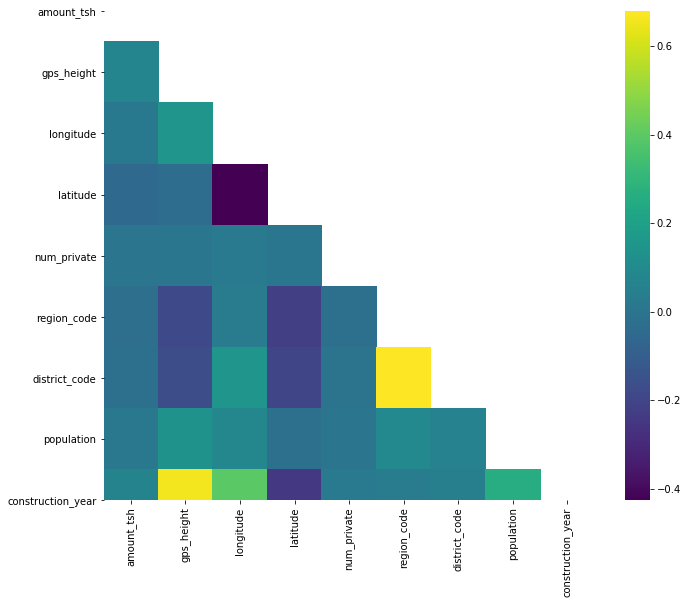

In [11]:
'''
    When you look at the data, one correlation stands out from the rest.
        1) gps_height and construction year
'''
du_num = du_X.select_dtypes(exclude='object')
corr = du_X.corr()
print("Correlation between numerical features\n\n", corr)

# # The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");


## Building Models

### First Simple Model - Logistic Regression

In [12]:
'''
    FSM: Logistic Regression : Recall Score 0.6682552875361601
'''
# Create an instance of WellProcessor
wp = WellProcessor()

# wp.fit(X_train)

# X_test = wp.transform(X_test)
# X_train = wp.transform(X_train)

param_grid = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [0.05],
    'estimator__solver' : ['lbfgs']}

model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)

'''
 Model 0: Estimator 0.05 solver lbfgs -  0.6682552875361601
'''

0.6579001136862485


'\n Model 0: Estimator 0.05 solver lbfgs -  0.6682552875361601\n'

### Scoring

In [13]:
'''
    Score FSM : Logical Regerssion
'''
print(" Model 0: Estimator 0.05 solver lbfgs - ", model.best_score_)

 Model 0: Estimator 0.05 solver lbfgs -  0.6579001136862485


### Confustion Matrix

[Text(0, 0.5, 'Func'),
 Text(0, 1.5, 'Non-Fun-Repair'),
 Text(0, 2.5, 'Functional')]

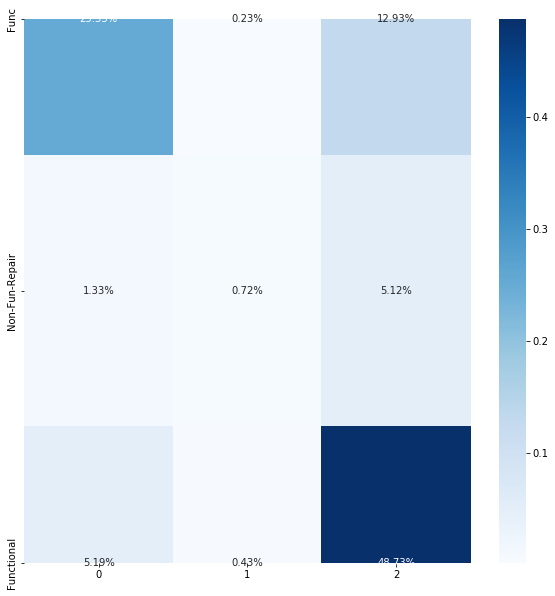

In [14]:
ypred = model.best_estimator_.predict(X_test)
cf_matrix = confusion_matrix(y_test, ypred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%',cmap='Blues')  # fmt='.2%',
ax.set_yticklabels(['Func', 'Non-Fun-Repair', 'Functional'], va='center', rotation = 90)

# Build Modelsl

## Logistic Regression

In [ ]:
# Create an instance of WellProcessor
wp = WellProcessor()

param_grid = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [0.02],
    'estimator__solver' : ['lbfgs']}

model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)

In [ ]:
'''
    Score FSM : Logical Regerssion
'''
print(" Model 0: Estimator 0.02 solver lbfgs - ", model.best_score_)

In [ ]:
for i in  np.arange(0.01, 0.1, 0.01):
    # Create an instance of WellProcessor
    wp = WellProcessor()

    param_grid = {
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [i],
        'estimator__solver' : ['lbfgs']}

    model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)
    print(" Model 0: Estimator {} solver lbfgs  ".format(i), model.best_score_)
    
    '''
       Recall Values cor Linear Regression Hyper Parameter C: Range 0.01.0.1
            0.6438194077059016
             Model 0: Estimator 0.01 solver lbfgs   0.6438194077059016
            0.6564757112894573
             Model 0: Estimator 0.02 solver lbfgs   0.6564757112894573
            0.6624476836895876
             Model 0: Estimator 0.03 solver lbfgs   0.6624476836895876
            0.6649132870333893
             Model 0: Estimator 0.04 solver lbfgs   0.6649132870333893
            0.6682552875361601
             Model 0: Estimator 0.05 solver lbfgs   0.6682552875361601
            0.6705015777249994
             Model 0: Estimator 0.060000000000000005 solver lbfgs   0.6705015777249994
            0.6720904237157769
             Model 0: Estimator 0.06999999999999999 solver lbfgs   0.6720904237157769
            0.6722001328215577
             Model 0: Estimator 0.08 solver lbfgs   0.6722001328215577
            0.6727478829219242
             Model 0: Estimator 0.09 solver lbfgs   0.6727478829219242    
    '''

In [ ]:
for i in  np.arange(0.1, 1.0, 0.1):
    # Create an instance of WellProcessor
    wp = WellProcessor()

    param_grid = {
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [i],
        'estimator__solver' : ['lbfgs']}

    model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)
    print(" Model 0: Estimator {} solver lbfgs  ".format(i), model.best_score_)
    '''
        Linear Regression parameter tuning with C: Range 0.1-1.0
        
0.6734054321765852
 Model 0: Estimator 0.1 solver lbfgs   0.6734054321765852
0.6758162860240955
 Model 0: Estimator 0.2 solver lbfgs   0.6758162860240955
0.675816301032181
 Model 0: Estimator 0.30000000000000004 solver lbfgs   0.675816301032181
0.6761452332444104
 Model 0: Estimator 0.4 solver lbfgs   0.6761452332444104
0.6771859389245957
 Model 0: Estimator 0.5 solver lbfgs   0.6771859389245957
0.6772955279656914
 Model 0: Estimator 0.6 solver lbfgs   0.6772955279656914
0.678226899742236
 Model 0: Estimator 0.7000000000000001 solver lbfgs   0.678226899742236
0.6791587367694345
 Model 0: Estimator 0.8 solver lbfgs   0.6791587367694345
0.6780626662614483
 Model 0: Estimator 0.9 solver lbfgs   0.6780626662614483
    '''

In [ ]:
for i in  np.arange(1, 10, 1):
    
    # Create an instance of WellProcessor
    wp = WellProcessor()

    param_grid = {
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [i],
        'estimator__solver' : ['lbfgs']}

    model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)
    print(" Model 0: Estimator {} solver lbfgs  ".format(i), model.best_score_)
    '''
        Linear Regression Model: Best value C=3
        0.6776791796580406
         Model 0: Estimator 1 solver lbfgs   0.6776791796580406
        0.6782270798392634
         Model 0: Estimator 2 solver lbfgs   0.6782270798392634
        0.6803089864664588
         Model 0: Estimator 3 solver lbfgs   0.6803089864664588
        0.6789939780056506
         Model 0: Estimator 4 solver lbfgs   0.6789939780056506
        0.6788298645895476
         Model 0: Estimator 5 solver lbfgs   0.6788298645895476
        0.6779534073982358
         Model 0: Estimator 6 solver lbfgs   0.6779534073982358
        0.6780078567328148
         Model 0: Estimator 7 solver lbfgs   0.6780078567328148
        0.6786652408985342
         Model 0: Estimator 8 solver lbfgs   0.6786652408985342
        0.6789941430945922
         Model 0: Estimator 9 solver lbfgs   0.6789941430945922
    '''

In [ ]:
for i in  np.arange(1, 10, 1):
    # Create an instance of WellProcessor
    wp = WellProcessor()

    param_grid = {
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [i],
        'estimator__solver' : ['lbfgs']}

    model = run_model(X_train,y_train, LogisticRegression(), param_grid=param_grid)
    print(" Model 0: Estimator {} solver lbfgs  ".format(i), model.best_score_)
    '''
      Linear Regression: Parameter Tuning: C=3 best recall score 0.6803089864664588
         Model 0: Estimator 1 solver lbfgs   0.6776791796580406
        0.6782270798392634
         Model 0: Estimator 2 solver lbfgs   0.6782270798392634
        0.6803089864664588
         Model 0: Estimator 3 solver lbfgs   0.6803089864664588
        0.6789939780056506
         Model 0: Estimator 4 solver lbfgs   0.6789939780056506
        0.6788298645895476
         Model 0: Estimator 5 solver lbfgs   0.6788298645895476
         
         
         Tried running 'saga' and 'newton-cg'. Both are computational heavy.
    '''

## Logistic Regression Parameter Tuning Summary:
- Linear Regression Model was run with L2 Loss Penalty
- Among a range of values from 0.01-5, the best C value is 3
- 'Saga' and 'Newton-CG' parameter solver are computationally expensive.
- Hence concluded the best recall score as 0.6803089864664588 for Hyper Parameters C=3 and Solver=lbfrg